# Model Inversion & Stealing

In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image
import torchvision
import os

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

In [2]:
seed = 42
seed = int(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [3]:
from torch.utils.data import Dataset, DataLoader
import h5py
from PIL import Image

#data_path = './data/Retina'
data_path = "D:/FD_heterogeniety/fedavgmodels-dev-tuning/data/Retina"

def load_hf_data(data_path, dataset_name='Retina', phase='train'):
    dataset_name = dataset_name
    data_path = data_path
    if dataset_name == 'Retina':
        ## this is pre-processed by Miao
        hf = h5py.File(
            os.path.join(data_path, dataset_name + '_' + phase + '.h5'), 'r')
        d = hf['examples']

        pixels = d['0']['pixels']
        label = d['0']['label']

    elif dataset_name == 'COVID':

        hf = h5py.File(
            os.path.join(data_path, 'COVID_data',
                         dataset_name + '_' + phase + '.h5'), 'r')
        pixels = hf['pixels']
        label = hf['label']

        ## change to uint8, original in the range of [0-1]
        pixels = np.asarray(pixels) * 255

    return pixels, label


class MyDataset(Dataset):

    def __init__(self, data, label, data_aug=False, phase='train'):
        self.data = data
        self.label = label

        if phase == 'train':
            # transform = transforms.Compose([
            #     transforms.RandomResizedCrop((224, 224), scale=(0.05, 1.05)),
            #     transforms.RandomHorizontalFlip(),
            #     transforms.ToTensor(),
            #     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5,
            #                                                     0.5]),
            # ])
            if not data_aug:
                transform = transforms.Compose([
                    transforms.RandomResizedCrop((224, 224), scale=(0.05, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ])
            else:
                # we need data augmentation
                transform = create_transform(
                    input_size=224,
                    is_training=True,
                    color_jitter=0.4,
                    auto_augment='rand-m9-mstd0.5-inc1',
                    re_prob=0.25,
                    re_mode='pixel',
                    re_count=1,
                    interpolation='bicubic',
                )
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5,
                                                                0.5]),
            ])

        self.transform = transform

    def __getitem__(self, index):

        x = self.data[index]
        y = self.label[index]
        ## if x is grayimage, then broadcast to 3 images
        ## ADNI to 3 channels
        if len(x.shape) < 3:
            x = np.stack([x, x, x], 2)

        x = np.asarray(x).astype('uint8')

        img = Image.fromarray(x)
        y = np.asarray(y).astype('int64')

        if self.transform is not None:
            img = self.transform(img)

        return img, y

    def __len__(self):
        return len(self.data)
    

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, or `cifar` while the split depth is between 1 and 6 for MNIST datasets, and 1 and 8 for the CIFAR dataset.

In [6]:
dataset = 'cifar'
dataset = 'Retina'
split_layer = 0
data_root = '/root/autodl-tmp'
if dataset == 'mnist':
    trainset = datasets.MNIST(data_root+'/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST(data_root+'/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST(data_root+'/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST(data_root+'/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10(data_root+'/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10(data_root+'/cifar', download=True, train=False, transform=transforms.ToTensor())
    #client, server, clone = CifarNet(), CifarNet(), CifarNet()
    client, server, clone = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10), ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10), ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)
elif dataset == 'Retina' :
    img, label = load_hf_data(data_path=data_path)
    trainset = MyDataset(img, label)
    img_test, label_test = load_hf_data(data_path=data_path, phase='test')
    testset = MyDataset(img_test, label_test)
    client, server, clone = ResNet18(BasicBlock, [2, 2, 2, 2], input_size=224, num_classes=2), ResNet18(BasicBlock, [2, 2, 2, 2], input_size=224, num_classes=2), ResNet18(BasicBlock, [2, 2, 2, 2], input_size=224, num_classes=2)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=1)

The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [7]:

#print(client)
#print(server)
client = client.to('cuda:0')
server = server.to('cuda:0')
clone = clone.to('cuda:0')
inverse_model = ResNet18Decoder1().to('cuda:0')

client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
trained = False
epochs = 10
if trained == True:
    server.load_state_dict(torch.load('server.pth'))
    client.load_state_dict(torch.load('client.pth'))
    print('Finish loading!')

elif trained == False:
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images = images.to('cuda:0')
            labels = labels.to('cuda:0')
            client_opt.zero_grad()
            server_opt.zero_grad()

            pred = server(client(images, end=split_layer), start=split_layer+1)
            #print(pred)

            loss = criterion(pred, labels)
            loss.backward()
            running_loss += loss

            server_opt.step()
            client_opt.step()
        else:
            print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')
    torch.save(server.state_dict(),'server.pth')
    torch.save(client.state_dict(),'client.pth')

Epoch: 0 Loss: 0.7706783413887024 Acc: 49.67551622418879
Epoch: 1 Loss: 0.6986440420150757 Acc: 49.85302763080541
Epoch: 2 Loss: 0.6968101859092712 Acc: 51.86500888099467
Epoch: 3 Loss: 0.691537082195282 Acc: 55.535820011841324


In [15]:
def plot_data(cfg, user_data, setup, scale=False, print_labels=False):
    """Plot user data to output. Probably best called from a jupyter notebook."""
    import matplotlib.pyplot as plt  # lazily import this here

    dm = torch.as_tensor(cfg.mean, **setup)[None, :, None, None]
    ds = torch.as_tensor(cfg.std, **setup)[None, :, None, None]
    data = user_data.clone().detach()
    data = data.to('cuda:0')

    if scale:
        min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
        # print(f'min_val: {min_val} | max_val: {max_val}')
        data = (data - min_val) / (max_val - min_val)
    else:
        data.mul_(ds).add_(dm).clamp_(0, 1)
    data = data.to(dtype=torch.float32)

    if data.shape[0] == 1:
        plt.axis("off")
        plt.imshow(data[0].permute(1, 2, 0).cpu())
        if print_labels:
            plt.title(f"Data with label {classes[labels]}")
    else:
        grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
        s = 24 if data.shape[3] > 150 else 6
        fig, axes = plt.subplots(grid_shape, grid_shape, figsize=(s, s))
        label_classes = []
        for i, (im, axis) in enumerate(zip(data, axes.flatten())):
            axis.imshow(im.permute(1, 2, 0).cpu())
            axis.axis("off")
        if print_labels:
            print(label_classes)
            

class data_cfg_default:
    size = (1_281_167,)
    classes = 2
    shape = (3, 224, 224)
    normalize = True
    #CIFAR
    '''mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)'''
    #Retina
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

setup = dict(device=torch.device("cuda:0"), dtype=torch.float)

We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

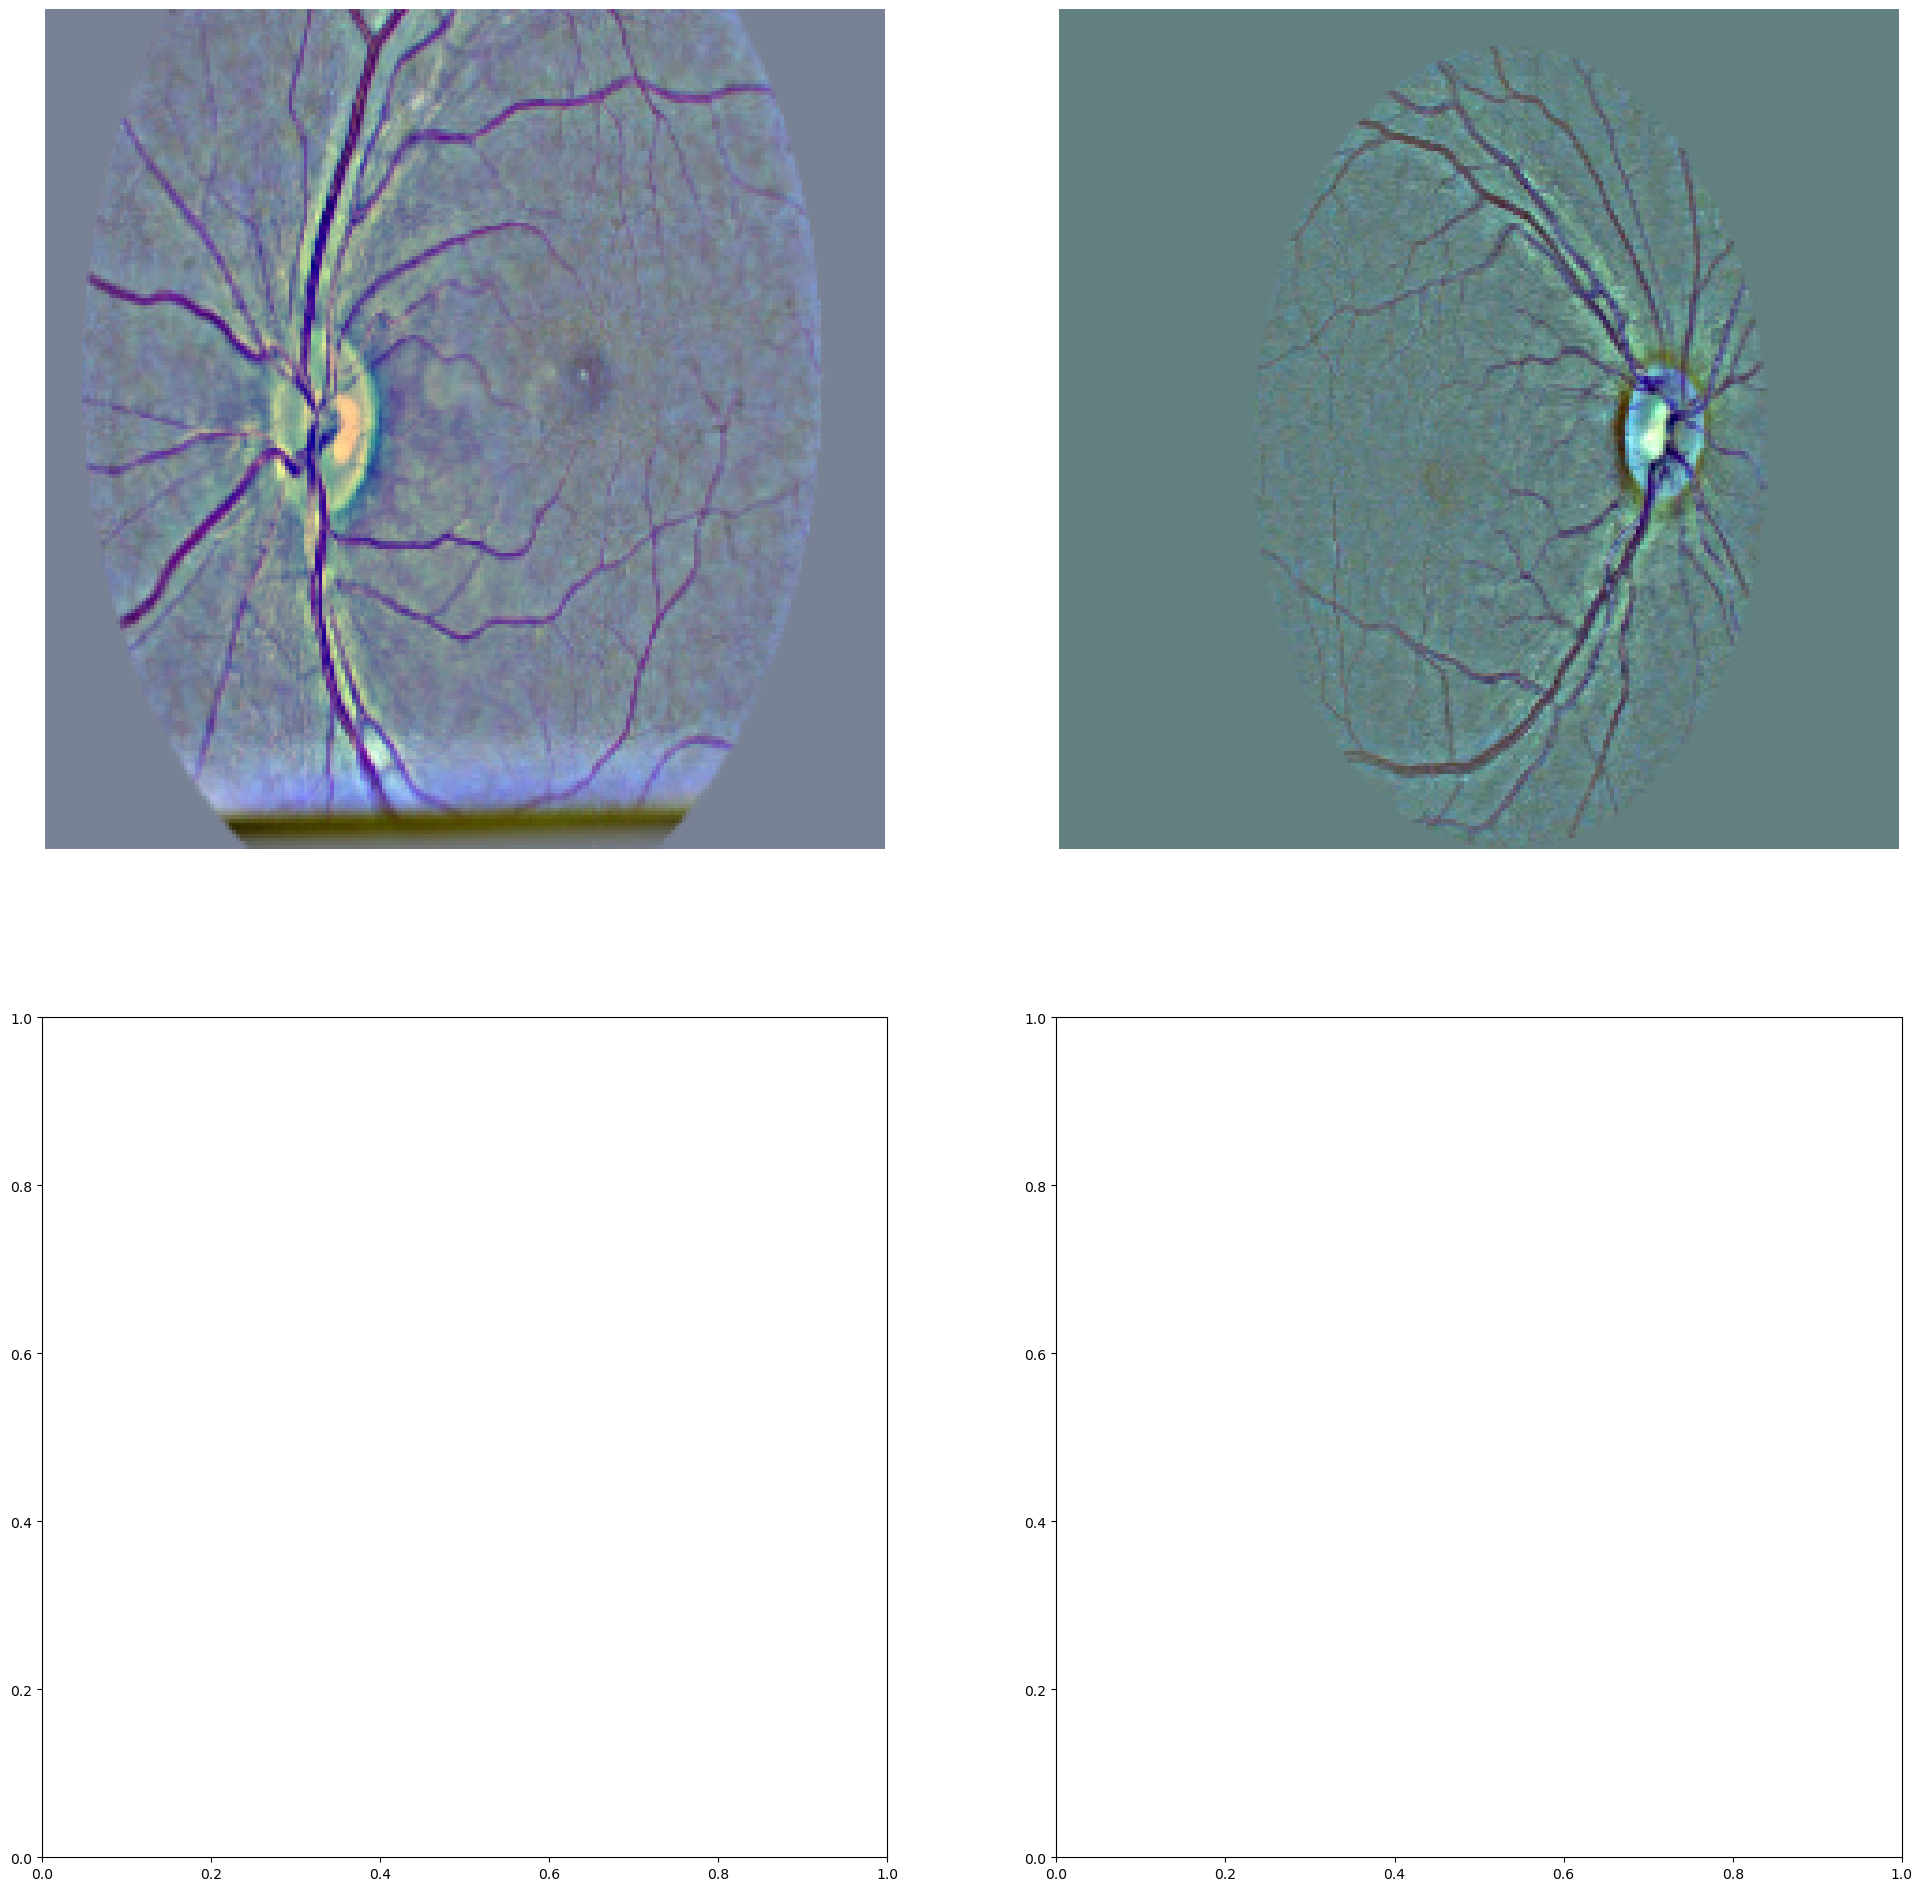

In [17]:
COUNT = 1
if dataset == 'Retina':
    inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(2)]
    targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
    #print(inversion_targets)
    
else:
    inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
    targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
    #inversion_data = torch.stack(inversion_targets)
mse = torch.nn.MSELoss()
if dataset == 'cifar':
    display_cifar(inversion_targets)

elif dataset == 'Retina':
    plot_data(data_cfg_default, torch.stack(inversion_targets), setup, scale=True)

else:
    display_imagelist(inversion_targets, 28, 28)
#print(inversion_targets[0])

We now launch the attack, iterating over the examples from the previous cell.

You can change the `main_iters`, `input_iters`, and `model_iters` variables to observe how the attack performs under different configurations.

ssim:0.007740578148514032
epoch:99 finished!
ssim:0.007517077028751373
epoch:199 finished!
ssim:0.007362531963735819
epoch:299 finished!
ssim:0.007241693791002035
epoch:399 finished!
ssim:0.007154437247663736
epoch:499 finished!
ssim:0.007088949903845787
epoch:599 finished!
ssim:0.007037265691906214
epoch:699 finished!
ssim:0.006994752679020166
epoch:799 finished!
ssim:0.006958785001188517
epoch:899 finished!
ssim:0.006920072715729475
epoch:999 finished!
ssim:0.002404541475698352
epoch:99 finished!
ssim:0.006255405489355326
epoch:199 finished!
ssim:0.006249825935810804
epoch:299 finished!
ssim:0.006234880071133375
epoch:399 finished!
ssim:0.006215100642293692
epoch:499 finished!
ssim:0.006195686757564545
epoch:599 finished!
ssim:0.006178649142384529
epoch:699 finished!
ssim:0.00616346625611186
epoch:799 finished!
ssim:0.00614951690658927
epoch:899 finished!
ssim:0.006136681418865919
epoch:999 finished!


RuntimeError: shape '[28, 28]' is invalid for input of size 150528

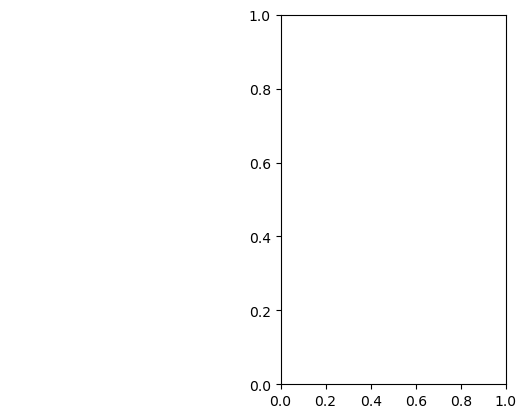

In [18]:
results, losses = [], []
#inverse_model = unsplit.model_inversion_black(inverse_model, split_layer, client, testloader, lambda_tv=0.1, lambda_l2=1, main_iters=1)
#inverse_model = inverse_model.to('cuda:0')
for idx, target in enumerate(targetloader):
    # obtain client output
    target = target.to('cuda:0')
    client_out = client(target, end=split_layer)
    '''client = client.eval()
    client_out = client(target)
    client = client.train()'''

    # perform the attack
    result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() , target, main_iters=1000, input_iters=100, model_iters=100)
    #result = unsplit.model_inversion_white(client, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100)
    #result = inverse_model(client_out)
    #result = unsplit.model_inversion_black(inverse_model, split_layer, client, client_out, testloader, lambda_tv=0.1, lambda_l2=1, main_iters=100)
    # save result
    if dataset == 'cifar':
        result = normalize(result)
    results.append(result)
    loss = mse(result, target)
    losses.append(loss)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
elif dataset == 'Retina':
    continue
else:
    display_imagelist(inversion_targets, 28, 28)
    display_imagelist(results, 28, 28)

In [28]:
#!pip install pytorch_msssim
import pytorch_msssim
from pytorch_msssim import ssim
#print(results[0])

sum = 0
for i in range(2):
    target = normalize(inversion_targets[i]).unsqueeze(0)
    #print(target)
    ssim_value = ssim(target.to('cpu'), normalize(results[i]).to('cpu'), data_range=1.0, size_average=True, nonnegative_ssim=True)
    print(ssim_value)
    sum = sum + ssim_value

average_ssim = sum/2
print(f'ssim:{average_ssim}')

tensor(0.5019)
tensor(0.6560)
ssim:0.578917384147644


In [29]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') 
loss_fn_vgg = lpips.LPIPS(net='vgg')
sum1 = 0
sum2 = 0
for i in range(2):
    target = normalize(inversion_targets[i]).unsqueeze(0)
    lpips_alex = loss_fn_alex(target.to('cpu'), normalize(results[i]).to('cpu'))
    lpips_vgg = loss_fn_vgg(target.to('cpu'), normalize(results[i]).to('cpu'))
    print(lpips_alex)
    print(lpips_vgg)
    sum1 = sum1 + lpips_alex
    sum2 = sum2 + lpips_vgg

average_lpips_alex = sum1/2
average_lpips_vgg = sum2/2
print(f'lpips_alex:{average_lpips_alex}')
print(f'lpips_vgg:{average_lpips_vgg}')   

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


D:\anaconda3\envs\my_en\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\my_en\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: D:\anaconda3\envs\my_en\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


D:\anaconda3\envs\my_en\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: D:\anaconda3\envs\my_en\lib\site-packages\lpips\weights\v0.1\vgg.pth
tensor([[[[0.2924]]]], grad_fn=<AddBackward0>)
tensor([[[[0.3249]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1630]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1935]]]], grad_fn=<AddBackward0>)
lpips_alex:tensor([[[[0.2277]]]], grad_fn=<DivBackward0>)
lpips_vgg:tensor([[[[0.2592]]]], grad_fn=<DivBackward0>)


In [30]:
import skimage
from skimage.metrics import peak_signal_noise_ratio

sum = 0
for i in range(2):
    target = normalize(inversion_targets[i]).unsqueeze(0)
    #print(target)
    psnr_value = ssim(target.to('cpu'), normalize(results[i]).to('cpu'), data_range=1.0)
    print(psnr_value)
    sum = sum + psnr_value

average_psnr = sum/2
print(f'PSNR:{average_psnr}')
    

tensor(0.5019)
tensor(0.6560)
PSNR:0.578917384147644


In [27]:
from PIL import Image
for i in range(2):
    
    image = normalize(inversion_targets[i]).to('cpu').detach().permute(1,2,0)*255
    #print(image.max())
    #print(image.min())
    image = image.numpy().astype(np.uint8)
    reconstruct = normalize(results[i]).to('cpu').squeeze(0).detach().permute(1,2,0)*255
    reconstruct = reconstruct.numpy().astype(np.uint8)
    #print(image)
    #print(image.shape)
    image = Image.fromarray(image)
    reconstruct = Image.fromarray(reconstruct)
    image.save(f'image{i}.jpg')
    reconstruct.save(f'reconstruct{i}.jpg')